**Predicting the occupancy status of an Airbnb listing**

In this notebook I will 

In [1]:
#Import first some useful libraries
#Import stuff
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
#import seaborn as sns
rcParams['font.family'] = 'sans-serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=8):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       
    #plt.rc('text', usetex=True)      
    plt.rc('font', size=fontsize)    
    plt.rc('xtick', direction='in')  
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) 

    return
plot_pretty()

# Data Preprocessing and Exploratory Data Analysis

Our first step is to prepare the available data.

In [2]:
# Import the table as a pandas dataframe
Airbnb_df = pd.read_csv('TH_data_challenge.tsv',sep='\t', header=0)
# Let's see the header
#Airbnb_df.head()    

## A short description of the dataset:

The dataset contains 184279 instances, each one related to a specific listing and  date. The column `dim_is_requested` carries the information about the availability of listing with anonymized id given in column `id_listing_anon` on the date given in `ds_night`. We have also 43 more feature columns, described in a file accompanying the above `tsv` file that describe properties of (or related to) the listing (or related to the market), such price, type, availability, demand within the market etc.

Here, before any data cleaning I want to start by checking for potential biases in the given dataset. 

### Unique listings

The first thing I want to check is if different listings are represented in a fair way in our dataset. First of all we can check that, although the number of instances is 184279, the number of unique listings is much smaller:


In [3]:
print(len(Airbnb_df.id_listing_anon.unique()))

10442


We have 10442 unique listings. Although we imagine that such a case can be hard, before any exploration it is good to check that the sample is not dominated by just a few of them.

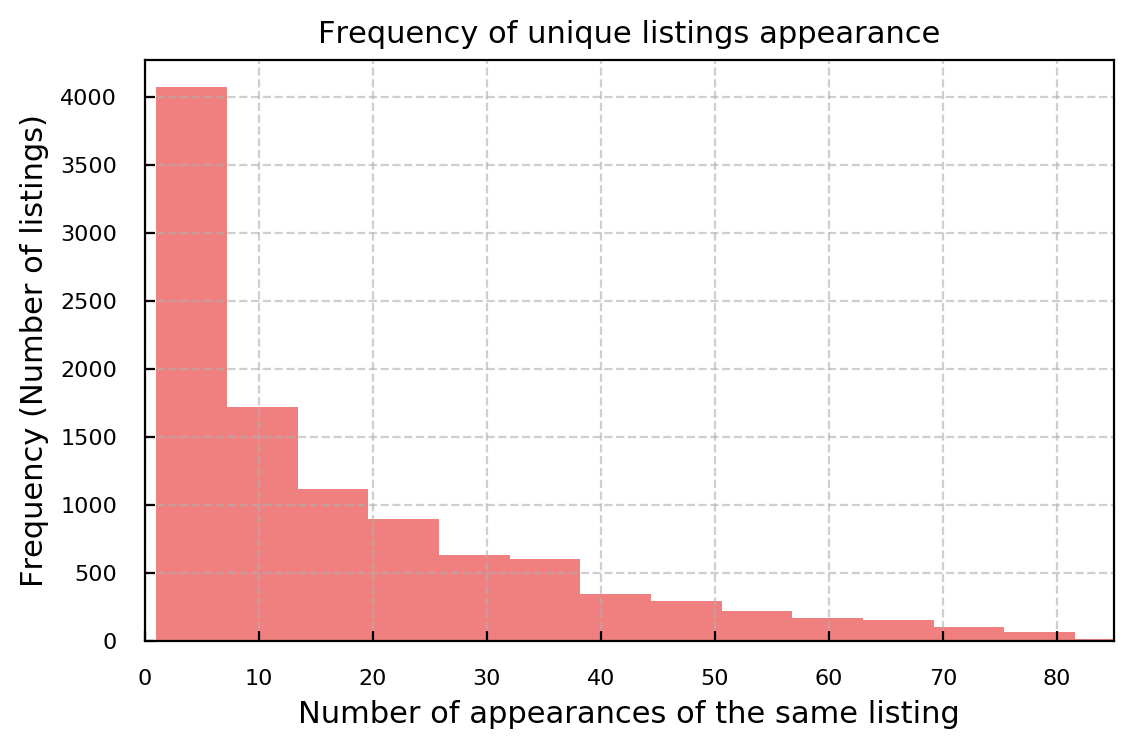

In [4]:
Unique_list = Airbnb_df.id_listing_anon.value_counts(normalize=False)

plt.figure(figsize=(5.7,3.8))

plt.hist(Unique_list.values, color='lightcoral', bins=15)
plt.grid(ls='--', alpha=0.6)

plt.xlabel('Number of appearances of the same listing', fontsize=11)
plt.ylabel('Frequency (Number of listings)', fontsize=11)
plt.title('Frequency of unique listings appearance', fontsize=11)
plt.xlim(0,85)
plt.tight_layout()
plt.show()


We see that $\sim 50\%$ of the listings appear less than 10 times in our list. Only a few appear more than 70 times. 70 is still a very small number compared to the number of instances, and thus is not going to significantly bias the results. At a second, more careful treatment, one should consider reject those listings with more than say $40$ appearances. 

### Date distribution

Another potential source of bias is the misrepresentation of specific days / periods in the given dataset. If, for example, June is overepresented in our dataset we may be able to achieve high accuracy for that month but be harder to generalize for other dates (overfitting).

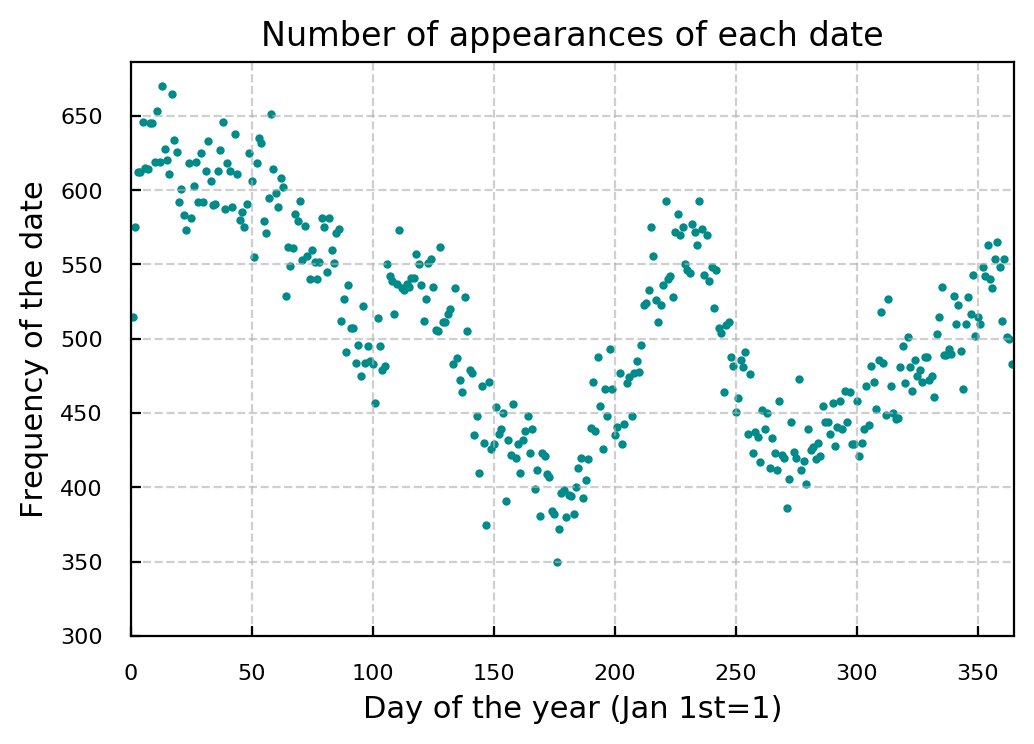

In [5]:
Unique_days = Airbnb_df.ds_night_day_of_year.value_counts(normalize=False)

plot_pretty()
plt.figure(figsize=(5.7,3.8))

plt.scatter(Unique_days.index.values,Unique_days.values, color='darkcyan', s=4.0)

plt.grid(ls='--', alpha=0.6)

plt.title('Number of appearances of each date', fontsize=12)
plt.xlabel('Day of the year (Jan 1st=1)', fontsize=11)
plt.ylabel('Frequency of the date', fontsize=11)
plt.xlim(0,365)
plt.ylim(300,)
plt.show()

We see that there is some variation, with the range of instances per day ranging from $\sim 350 - 650$. This can cause some problems, but since we not have more extreme variations (like days/monts totally not represented in the dataset), I will not make any adjustments in my model.


Also, the `ds_night_day_of_year` has values in the range 1-364, as we can see above. I will discuss more about that in a while, but this categorical feature has to be one-hot-encoded. However this would add 364 columns in our feature matrix and is an unecessary fine-graning process. Instead, I will assign each day to the corresponding month and I will use one-hot-encoding on that feature.

### Target Classes

We have two target classes in the `dim_is_requested` column.

In [6]:
from sklearn.preprocessing import LabelEncoder
# Convert the target class from Boolean True/False to 0 and 1 that 
# Classifiers can understand
y_target = LabelEncoder().fit_transform(Airbnb_df['dim_is_requested'])

print(len(y_target[y_target==0]))
print(len(y_target[y_target==1]))

123769
60510


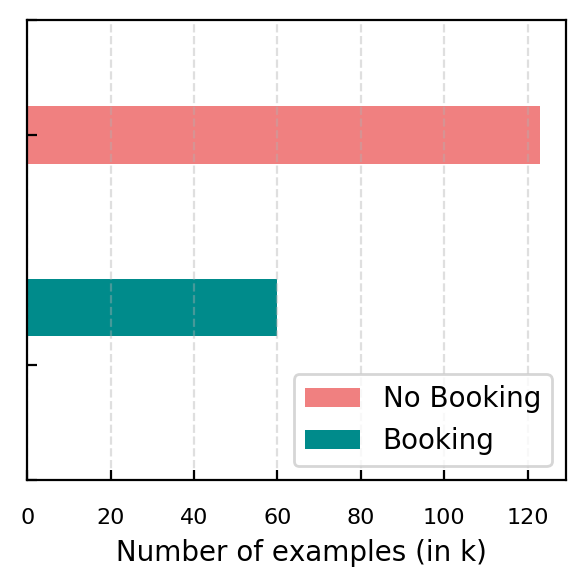

In [7]:
data_0 = [len(y_target[y_target==0])/1000]
data_1 = [len(y_target[y_target==1])/1000]

fig = plt.figure(figsize = (3.0,3.0))
plt.barh(4,data_0, height =0.5, color='lightcoral', label='No Booking')
plt.barh(2.5,data_1, height =0.5, color='darkcyan', label='Booking')
plt.grid(ls='--', axis='x', alpha=0.4)

plt.yticks([1,2,4,5], (), fontsize=10)
plt.xlabel(' Number of examples (in k)', fontsize=10)

plt.legend(frameon=True, loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()


We see that we have significantly more instances (examples) where finally there was no booking than the cases where there was one. We thus have a **class imbalance** problem that we should take care during the classification process.

## Data cleaning and transformation (Missing values, encodings etc) 

Now let's focus on the other features and their values.
Let's get some information for the columns in the dataset.

In [8]:
Airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184279 entries, 0 to 184278
Data columns (total 46 columns):
dim_is_requested                                      184279 non-null bool
ds_night                                              184279 non-null object
ds                                                    184279 non-null object
id_listing_anon                                       184279 non-null object
id_user_anon                                          184279 non-null object
m_effective_daily_price                               184279 non-null float64
m_pricing_cleaning_fee                                184279 non-null float64
dim_market                                            184279 non-null object
dim_lat                                               184279 non-null float64
dim_lng                                               184279 non-null float64
dim_room_type                                         184279 non-null object
dim_person_capacity                     

### Missing values
The first column to the right shows the number of non-null elements of each feature. Most of them do not have missing values; however some of them have.

$\bullet$ The columns `p2_p3_click_through_score` and `p3_inquiry_score` have a very small number of non-missing values (less than $1/3$ of the total instances). I will drop these columns.

$\bullet$ For the other columns that there are missing (for example `image_quality_score`) value I will follow an imputation strategy, using the `median` of the entire column.

### Bad values

Checking the features I noticed that the column `m_effective_daily_price`, describing the effective daily price on listing, had negative values. These have to be dropped. Actually, one can argue that there are other unphysical values, very small (say, less than 10 USD), but I will be conservative and drop those listings with just negative or zero values (there are 62 of them).

In [9]:
price = Airbnb_df['m_effective_daily_price'].values
print(len(price[price<=0]))

62


### Categorical features

The dataset contains some categorical (non-numerical) features, but also some disguised categorical features (they are numerical features however we cannot keep their face value).

- Nominal features:

 `dim_market`: This takes values 'Paris', 'Los Angeles', 'San Francisco'. Has to be one-hot encoded.
 
 
- Ordinal features: 

`dim_room_type`. This has the categories 'Shared room', 'Private room', 'Entire home/apt'. Makes sence to categorize them as: 'Shared room'=1, 'Private room'=2, 'Entire home/apt' =3.

`dim_is_instant_bookable`. This takes the Boolean values `True/False`. Can be encoded as 0/1.

- The **tricky** categorical features:
  
  These are features that come as numerical values, however *they are not*. The column `ds_night_day_of_week` shows the day of the week with 0='Sunday', 1='Monday' etc. However there is no reason to believe that Monday>Sunday. So, actually we have to add binarized columns for each one of the days (one-hot-encoding).
  
  Similarly, the  column `ds_night_day_of_year` shows the day of the year, with values $1,\dots, 364$. Again, having a numerical value that shows order does not make sense. This time though we cannot add 364 columns; I will encode them by just using the month the day belongs to.
  
  
### Columns I will not use

I will not use the following columns for my predictions:

$\bullet$ `id_listing_anon` The anonymized id of the listing. We checked that most listings have unique entrances, thus this does not add up information.

$\bullet$ `id_user_anon` The anonymized id of the host. Although it is true that a specific host may offer better amenities in his listings and thus there can be a correlation between bookings and host, trying to model that will significantly increase the complexity. I'll drop it.

$\bullet$ `ds_night` and `ds`. The time dependence is captured in the `ds_night_day_of_year` column (and the one about the day of the week).

$\bullet$ `dim_lat`, `dim_lng`: The latitude/longitude of each listing. Although this can give us information about individual neighborhoods, here I use just the city a listing belongs to (and through the KDT clusters geographical information comes in).

$\bullet$ Finally I will drop the `kdt_score`. I cannot understand this feature, and I prefer not to use a feature I cannot understand.

Let's perform the cleaning and transformation of the data!

### Log of prices

Finally, it is a good strategy (because of large range of values) to convert the prices (columns `m_effective_daily_price` and `price_booked_most_recent` to their log values.

In [10]:
# Make a list here of the columns I will drop
cols_to_drop = ['p2_p3_click_through_score','p3_inquiry_score', 'id_listing_anon', 'id_user_anon',
                'ds_night','ds', 'dim_lat', 'dim_lng', 'kdt_score']

a = Airbnb_df.drop(cols_to_drop, axis=1)
# now dro the rows that have effective daily prices less than zero
b = a[a['m_effective_daily_price']>0]

In [11]:
# Now perform one-hot-encoding on the dim market, ds_night_day_of_week columns
# The easiest way to do it is through the get dummies class from pandas 
c = pd.get_dummies(b, columns=['dim_market','ds_night_day_of_week'])

# Now let's encode the ordinal dim_room_type
# First, create a map from room type to a numerical value
room_mapper = {'Shared room':1,
              'Private room':2,
              'Entire home/apt':3}

c['dim_room_type'] = c['dim_room_type'].replace(room_mapper)
# Now let's encode dim_is_instant_bookable from true/false to 0/1
book_mapper = {False: 0,
              True: 1}
c['dim_is_instant_bookable'] = c['dim_is_instant_bookable'].replace(book_mapper)
#c.head()

Finally, let's do the harder transformation, converting the days to months and encoding them (use dummies). Assume all are normal and not leap years

In [12]:
criteria = [c['ds_night_day_of_year'].between(1, 31), 
            c['ds_night_day_of_year'].between(32, 59),
            c['ds_night_day_of_year'].between(60, 90),
            c['ds_night_day_of_year'].between(91, 120),
           c['ds_night_day_of_year'].between(121, 151),
           c['ds_night_day_of_year'].between(152, 181),
           c['ds_night_day_of_year'].between(182, 212),
           c['ds_night_day_of_year'].between(213, 243),
           c['ds_night_day_of_year'].between(244, 273),
           c['ds_night_day_of_year'].between(274, 304),
           c['ds_night_day_of_year'].between(305, 334),
           c['ds_night_day_of_year'].between(335, 364),]
values = ['Jan','Feb','Mar','April','May','June','July','August',
          'September','October','Novembr','December']
# Be careful not to re-run this, after running once, it will convert everything to 0
c['ds_night_day_of_year'] = np.select(criteria, values, 0)

In [13]:
# Now get dummies
d = pd.get_dummies(c, columns=['ds_night_day_of_year'])

The final step in the data pre-processing is to impute the missing values (of the columns that have such values) using a `median` strategy (median, to be less sensitive to extreme values).

Before doing that, let's get again the classes and then drop the column from our features dataframe.

In [14]:
y_target = LabelEncoder().fit_transform(d['dim_is_requested'])
e = d.drop('dim_is_requested', axis=1)

In [20]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan,strategy="median")
imputer.fit(e)
X_mat = imputer.transform(e)

Now, this is just a simple numpy array, let's convert it to a dataframe.

In [41]:
Airbnb_df_new = pd.DataFrame(X_mat, columns=e.columns)

Finally let's make the prices log.

In [45]:
Airbnb_df_new['m_effective_daily_price'] = Airbnb_df_new['m_effective_daily_price'].apply(np.log10)
Airbnb_df_new['price_booked_most_recent'] = Airbnb_df_new['price_booked_most_recent'].apply(np.log10)

# Feature Selection and Engineering

In [67]:
#Airbnb_df_new.head()